In [ ]:
import pandas as pd
# Excelファイルを読み込む
df = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\ver1_20250729.xlsx")
print(df.columns)

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor

# --- 1. データ準備 ---
df = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\ver1_20250729.xlsx")
idx_event = df[['INDEX', 'Event']]
df_values = df.drop(columns=['INDEX','Event','付属_1','PI','Hard_endpoint'])

# --- 2. LGBMRegressor を推定器に指定 ---
est_lgb = LGBMRegressor(
    n_estimators=50,      # 木の本数
    learning_rate=0.1,    # 学習率
    n_jobs=-1,            # 全コア並列
    random_state=0
)

imp = IterativeImputer(
    estimator=est_lgb,
    max_iter=5,           # イテレーション回数
    random_state=0,
    initial_strategy='mean'
)

# --- 3. 補完＋結合を一気に実行 ---
df_imputed = pd.concat([
    pd.DataFrame(
        imp.fit_transform(df_values),
        columns=df_values.columns,
        index=df.index
    ),
    idx_event
], axis=1)

# --- 4. 結果確認 ---
print(df_imputed.isna().sum())


In [14]:
# 完全データセットをエクセルファイルに保存
df_imputed.to_excel('completed_data_20250729.xlsx', index=False)

In [ ]:
import pandas as pd
completed_data = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250729.xlsx") 
print(completed_data.columns)

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 1. ランダムシード
RANDOM_STATE = 42

# 2. completed_data のコピーと明示的 INDEX 列（すでにある場合はスキップ）
completed_data = completed_data.copy()
if "INDEX" not in completed_data.columns:
    completed_data["INDEX"] = completed_data.index

# 3. Stratified split を実施
train_df, holdout_df = train_test_split(
    completed_data,
    test_size=0.2,
    stratify=completed_data["Event"],
    random_state=RANDOM_STATE
)

# 4. INDEX による突合用データフレーム作成
split_info = pd.DataFrame({
    "INDEX": completed_data["INDEX"],
    "Set": np.where(completed_data["INDEX"].isin(train_df["INDEX"]), "Train", "Holdout")
})

# 5. completed_data に突合（マージ）
completed_data = completed_data.merge(split_info, on="INDEX", how="left")

# 6. 保存（任意）
completed_data.to_csv("completed_data_with_split.csv", index=False)

# 7. 結果確認（オプション）
print(completed_data["Set"].value_counts())


Set
Train      28561
Holdout     7141
Name: count, dtype: int64


In [ ]:
# -*- coding: utf-8 -*-
"""
Block-1 fully revised  v12  （2025-07-31 INDEX-key fix）
───────────────────────────────────────────────────────
 * INDEX 列をインデックスにしてキー不整合を解消
 * bootstrap / F1 関連を numpy 配列で処理（KeyError 回避）
 * .values 参照を削除
───────────────────────────────────────────────────────
"""

# ───────── Imports
from __future__ import annotations
import warnings, random, pickle, math
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import scipy.stats as _st
import optuna, xgboost as xgb, lightgbm as lgb

from sklearn.base          import BaseEstimator, TransformerMixin
from sklearn.compose       import ColumnTransformer
from sklearn.pipeline      import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import RobustScaler
from sklearn.impute        import SimpleImputer
from sklearn.linear_model  import LogisticRegression
from sklearn.calibration   import CalibratedClassifierCV
from sklearn.metrics       import roc_auc_score, average_precision_score, brier_score_loss, \
                                 precision_recall_curve, f1_score
from category_encoders      import TargetEncoder

# ───────── Globals
RANDOM_STATE   = 42
N_SPLITS_TUNE  = 5
N_TRIALS       = 100
PATIENCE       = 20
N_BOOTSTRAP    = 3000

np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

RESULTS_DIR = Path(f"results_{datetime.now():%Y%m%d_%H%M}")
RESULTS_DIR.mkdir(exist_ok=True)

# ───────── Transformer
class WinsorizeLog1pTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, p_low=.005, p_high=.995, skew_thr=1.0):
        self.p_low, self.p_high, self.skew_thr = p_low, p_high, skew_thr
    def fit(self, X, y=None):
        df = pd.DataFrame(X).astype(float)
        self.q_ = {c: df[c].quantile([self.p_low, self.p_high]).values for c in df}
        self.logmask_ = {c: (df[c]>=0).all() and abs(df[c].skew())>self.skew_thr for c in df}
        return self
    def transform(self, X):
        df = pd.DataFrame(X).astype(float).copy()
        for c in df:
            lo, hi = self.q_[c]
            df[c]  = df[c].clip(lo, hi)
            if self.logmask_[c]: df[c] = np.log1p(df[c])
        return df.values

# ───────── GPU flags
def xgb_gpu_params()->Dict:
    return dict(tree_method="gpu_hist", predictor="gpu_predictor",
                device="cuda", deterministic=True, random_state=RANDOM_STATE)
def lgb_gpu_flag()->Dict:
    try: return dict(device="gpu", deterministic=True)
    except: return {}

# ───────── Metric helpers
def calib_slope_int(y, p):
    eps = 1e-15
    p   = np.clip(p, eps, 1-eps)
    log = np.log(p/(1-p)).reshape(-1,1)
    lr  = LogisticRegression(random_state=RANDOM_STATE).fit(log, y)
    return lr.coef_[0][0], lr.intercept_[0]

def _metric_set(y, p):
    return (roc_auc_score(y, p),
            average_precision_score(y, p),
            brier_score_loss(y, p),
            *calib_slope_int(y, p))

def bootstrap_ci(y, p, n_boot=N_BOOTSTRAP, seed=RANDOM_STATE, alpha=.05):
    y = np.asarray(y); p = np.asarray(p)
    rng   = np.random.RandomState(seed)
    idx   = np.arange(len(y))
    stats = np.array([_metric_set(y[s], p[s])
                      for s in rng.choice(idx, (n_boot, len(idx)), True)])
    pt    = _metric_set(y, p)
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)], axis=0)
    keys  = ["AUROC","PR_AUC","Brier","CalSlope","CalInt"]
    return {k:(pt[i], lo[i], hi[i]) for i,k in enumerate(keys)}

def best_f1_threshold(y, p):
    y = np.asarray(y); p = np.asarray(p)
    pr, rc, thr = precision_recall_curve(y, p)
    f1          = 2*pr*rc/(pr+rc+1e-15)
    i           = int(np.nanargmax(f1))
    thr_best    = thr[i] if i < len(thr) else 1.0
    return float(thr_best), float(f1[i])

# ───────── DeLong (unchanged)
def _compute_midrank(x):
    J = np.argsort(x); Z = x[J]; N=len(x); T=np.zeros(N); i=0
    while i < N:
        j=i
        while j<N and Z[j]==Z[i]: j+=1
        T[i:j]=.5*(i+j-1); i=j
    T2=np.empty(N); T2[J]=T+1; return T2
def _fast_delong(preds_sorted_T, m):
    n  = preds_sorted_T.shape[1]-m; k=preds_sorted_T.shape[0]
    v01=np.zeros((k,m)); v10=np.zeros((k,n)); aucs=np.empty(k)
    for r in range(k):
        x,y=preds_sorted_T[r,:m],preds_sorted_T[r,m:]
        tx=_compute_midrank(np.r_[x,y])[:m]; ty=_compute_midrank(np.r_[x,y])[m:]
        aucs[r]=(tx.sum()-m*(m+1)/2)/(m*n)
        v01[r]=(tx-tx.mean())/n; v10[r]=1-(ty-ty.mean())/m
    S=np.cov(v01)/m + np.cov(v10)/n
    return aucs,S
def delong_roc_test(y,p1,p2):
    y,p1,p2 = map(np.asarray,(y,p1,p2)); m=int((y==1).sum())
    order   = np.argsort(-p1)
    p1s,p2s,ys = p1[order],p2[order],y[order]
    pos,neg    = np.where(ys==1)[0], np.where(ys==0)[0]
    aucs,S     = _fast_delong(np.vstack([np.r_[p1s[pos],p1s[neg]],
                                         np.r_[p2s[pos],p2s[neg]]]), m)
    diff = aucs[1]-aucs[0]; var=S[0,0]+S[1,1]-2*S[0,1]
    z    = np.abs(diff)/math.sqrt(var) if var>0 else np.inf
    return diff, 2*(1-_st.norm.cdf(z))

# ───────── Estimator & pipeline builders
def build_estimator(name, pos_w):
    if name == "Logistic":
        mdl = LogisticRegression(solver="liblinear", max_iter=1000,
                                 random_state=RANDOM_STATE)
        space = {
            "model__C":
              optuna.distributions.FloatDistribution(1e-3, 1e1, log=True),
            "model__class_weight":
              optuna.distributions.CategoricalDistribution([None,"balanced"])
        }
    elif name == "XGBoost":
        low, hi = .5*pos_w, 1.5*pos_w
        mdl = xgb.XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                                n_estimators=1200, **xgb_gpu_params())
        space = {
            "model__max_depth":
              optuna.distributions.IntDistribution(3,9),
            "model__learning_rate":
              optuna.distributions.FloatDistribution(1e-3,3e-2,log=True),
            "model__min_child_weight":
              optuna.distributions.IntDistribution(1,10),
            "model__gamma":
              optuna.distributions.FloatDistribution(0,5),
            "model__subsample":
              optuna.distributions.FloatDistribution(.5,.9),
            "model__colsample_bytree":
              optuna.distributions.FloatDistribution(.5,.9),
            "model__reg_alpha":
              optuna.distributions.FloatDistribution(1e-3,10,log=True),
            "model__reg_lambda":
              optuna.distributions.FloatDistribution(1e-3,10,log=True),
            "model__scale_pos_weight":
              optuna.distributions.FloatDistribution(low,hi),
            "model__n_estimators":
              optuna.distributions.IntDistribution(300,800,step=100)
        }
    else:  # LightGBM
        low, hi = .5*pos_w, 1.5*pos_w
        mdl = lgb.LGBMClassifier(objective="binary", metric="aucpr",
                                 n_estimators=1200, random_state=RANDOM_STATE,
                                 **lgb_gpu_flag())
        space = {
            "model__num_leaves":
              optuna.distributions.IntDistribution(31,255),
            "model__learning_rate":
              optuna.distributions.FloatDistribution(1e-3,3e-2,log=True),
            "model__feature_fraction":
              optuna.distributions.FloatDistribution(.5,.9),
            "model__bagging_fraction":
              optuna.distributions.FloatDistribution(.5,.9),
            "model__bagging_freq":
              optuna.distributions.IntDistribution(1,7),
            "model__lambda_l1":
              optuna.distributions.FloatDistribution(1e-3,10,log=True),
            "model__lambda_l2":
              optuna.distributions.FloatDistribution(1e-3,10,log=True),
            "model__scale_pos_weight":
              optuna.distributions.FloatDistribution(low,hi),
            "model__n_estimators":
              optuna.distributions.IntDistribution(300,800,step=100)
        }
    return mdl, space

def build_pipe(model, cat_cols, num_cols):
    transformers=[]
    if cat_cols:
        cat_pipe = Pipeline([
            ("enc",TargetEncoder(cols=cat_cols,smoothing=0.3,
                                 handle_unknown="impute")),
            ("imp",SimpleImputer(strategy="most_frequent"))
        ])
        transformers.append(("cat",cat_pipe,cat_cols))
    if num_cols:
        num_pipe = Pipeline([
            ("win",WinsorizeLog1pTransformer()),
            ("imp",SimpleImputer(strategy="median")),
            ("sc",RobustScaler())
        ])
        transformers.append(("num",num_pipe,num_cols))
    pre = ColumnTransformer(transformers,
                            remainder="passthrough" if not transformers else "drop",
                            n_jobs=1)
    return Pipeline([("pre",pre),("model",model)])

# ───────── CV + early-stopping
def cv_predict_proba_es(pipe, X:pd.DataFrame, y, n_splits=N_SPLITS_TUNE):
    cv   = StratifiedKFold(n_splits=n_splits, shuffle=True,
                           random_state=RANDOM_STATE)
    oof  = np.empty(len(y))
    for tr,va in cv.split(X, y):
        X_tr,y_tr = X.iloc[tr], y[tr]
        X_va,y_va = X.iloc[va], y[va]
        mdl_cls   = type(pipe.named_steps["model"])
        if mdl_cls in (xgb.XGBModel, lgb.LGBMModel):
            pipe.fit(X_tr,y_tr,
                     model__eval_set=[(X_va,y_va)],
                     model__eval_metric="aucpr",
                     model__early_stopping_rounds=50,
                     model__verbose=False)
        else:
            pipe.fit(X_tr,y_tr)
        oof[va] = pipe.predict_proba(X_va)[:,1]
    return oof

# ───────── Optuna tuner
def tune(pipe, space, X:pd.DataFrame, y):
    def objective(trial):
        for prm, dist in space.items():
            if isinstance(dist, optuna.distributions.FloatDistribution):
                pipe.set_params(**{
                    prm: trial.suggest_float(prm, dist.low, dist.high, log=dist.log)})
            elif isinstance(dist, optuna.distributions.IntDistribution):
                pipe.set_params(**{
                    prm: trial.suggest_int(prm, dist.low, dist.high, step=dist.step)})
            else:
                pipe.set_params(**{
                    prm: trial.suggest_categorical(prm, dist.choices)})
        p = cv_predict_proba_es(pipe, X, y)
        return average_precision_score(y, p)

    study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(objective, n_trials=N_TRIALS,
                   callbacks=[lambda s,t:
                              s.stop() if t.number-s.best_trial.number>=PATIENCE else None],
                   show_progress_bar=False)
    pipe.set_params(**study.best_params)
    best = {k.replace("model__",""):v for k,v in study.best_params.items()}
    return pipe, best

# ───────── Hold-out evaluation
def experiment_metrics(model_name, Xd:pd.DataFrame, yd, Xh:pd.DataFrame, yh,
                       cat, num):
    pos_w=(yd==0).sum()/max((yd==1).sum(),1)
    base,space = build_estimator(model_name, pos_w)
    pipe,best  = tune(build_pipe(base, cat, num), space, Xd, yd)

    final = CalibratedClassifierCV(pipe, method="isotonic", cv=N_SPLITS_TUNE)
    final.fit(Xd, yd)
    p = final.predict_proba(Xh)[:,1]

    ci  = bootstrap_ci(yh, p)
    thr, f1_pt = best_f1_threshold(yh, p)
    rng = np.random.RandomState(RANDOM_STATE)
    f1_bs = [f1_score(yh[s], (p[s]>=thr).astype(int))
             for s in rng.choice(np.arange(len(yh)),
                                 (N_BOOTSTRAP, len(yh)), True)]
    lo_f1, hi_f1 = np.percentile(f1_bs, [2.5,97.5])
    ci["F1_best"] = (f1_pt, lo_f1, hi_f1)
    ci["F1_thr"]  = (thr, np.nan, np.nan)

    flat = {k:pt for k,(pt,_,_) in ci.items()}
    for k,(pt,lo,hi) in ci.items():
        flat[f"{k}_lo"] = lo; flat[f"{k}_hi"] = hi
    return p, flat, best, final

# ───────── LOGO / facility
def calculate_logo_metrics(model, X:pd.DataFrame, y, cat, num, groups, best):
    pos_w=(y==0).sum()/max((y==1).sum(),1)
    base,_ = build_estimator(model, pos_w)
    pipe   = build_pipe(base, cat, num)
    pipe.set_params(**{f"model__{k}":v for k,v in best.items()})
    calib  = CalibratedClassifierCV(pipe, method="isotonic", cv=N_SPLITS_TUNE)

    preds = np.empty(len(y))
    logo  = LeaveOneGroupOut()
    for tr,te in logo.split(X, y, groups):
        calib.fit(X.iloc[tr], y[tr])
        preds[te] = calib.predict_proba(X.iloc[te])[:,1]

    ci  = bootstrap_ci(y, preds)
    thr, f1_pt = best_f1_threshold(y, preds)
    rng = np.random.RandomState(RANDOM_STATE)
    f1_bs = [f1_score(y[s], (preds[s]>=thr).astype(int))
             for s in rng.choice(np.arange(len(y)), (N_BOOTSTRAP,len(y)), True)]
    lo_f1, hi_f1 = np.percentile(f1_bs, [2.5,97.5])
    ci["F1_best"] = (f1_pt, lo_f1, hi_f1)
    ci["F1_thr"]  = (thr, np.nan, np.nan)

    out={}
    for k,(pt,lo,hi) in ci.items():
        out[f"LOGO_{k}"]=pt
        out[f"LOGO_{k}_lo"]=lo
        out[f"LOGO_{k}_hi"]=hi
    return out, preds

def calculate_facility_metrics(model, X_df:pd.DataFrame, y, cat, num,
                               groups, best):
    res={}
    for fid in np.sort(groups.unique()):
        tr, te = (groups!=fid), (groups==fid)
        pos_w  = (y[tr]==0).sum()/max((y[tr]==1).sum(),1)
        base,_ = build_estimator(model,pos_w)
        pipe   = build_pipe(base, cat, num)
        pipe.set_params(**{f"model__{k}":v for k,v in best.items()})
        calib  = CalibratedClassifierCV(pipe, method="isotonic", cv=N_SPLITS_TUNE)
        calib.fit(X_df.loc[tr], y[tr])
        p = calib.predict_proba(X_df.loc[te])[:,1]

        ci  = bootstrap_ci(y[te], p)
        thr, f1_pt = best_f1_threshold(y[te], p)
        rng = np.random.RandomState(RANDOM_STATE)
        f1_bs = [f1_score(y[te][s], (p[s]>=thr).astype(int))
                 for s in rng.choice(np.arange(len(y[te])),
                                     (N_BOOTSTRAP,len(y[te])), True)]
        lo_f1, hi_f1 = np.percentile(f1_bs, [2.5,97.5])
        ci["F1_best"] = (f1_pt, lo_f1, hi_f1)
        ci["F1_thr"]  = (thr, np.nan, np.nan)

        for k,(pt,lo,hi) in ci.items():
            res[f"Fac{fid}_{k}"]    = pt
            res[f"Fac{fid}_{k}_lo"] = lo
            res[f"Fac{fid}_{k}_hi"] = hi
    return res

# ───────── Main
if __name__ == "__main__":
    DATA_PATH = r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250729.xlsx"
    df = pd.read_excel(DATA_PATH).set_index("INDEX")     # ← INDEX をキーに
    df["付属_1"] = df["付属_1"].astype(int)

    CAT_PRE = [ "Male","Dialysis","CHF","Malig","β-blocker","Oral steroids",
                "DeliMed","Anticoag","Antiplatelet","AntiCa","Opioid",
                "Proc-Eye","Proc-Face/Neck","Proc-Thorax","Proc-MSK","Proc-ENT",
                "Proc-Neuro","Proc-Genital","Proc-Urinary","Proc-Skin","Proc-Abd",
                "ResectNum","HighRiskProc" ]
    NUM_PRE = [ "ASA","Age","BMI","Alb","BUN","CRP","Cre","Hb","K","Na","PLT",
                "T-Bil","WBC" ]
    CAT_INTRA = CAT_PRE.copy()
    NUM_INTRA = NUM_PRE + ["RBC Tx","FFP Tx","PLT Tx","FluidBal",
                           "OpTime","HR at 6h","MAP at 6h"]

    VARIANTS = {
        "①Pre-op":          (CAT_PRE, NUM_PRE),
        "②Peri-op+Intra":   (CAT_INTRA, NUM_INTRA)
    }
    MODELS = ["Logistic","XGBoost","LightGBM"]

    summary, hparams = [], []

    for variant,(cat_raw,num_raw) in VARIANTS.items():
        print(f"\n=== {variant} ===")
        CAT = [c for c in cat_raw if c in df.columns]
        NUM = [n for n in num_raw if n in df.columns]
        if not CAT and not NUM:
            raise ValueError(f"{variant}: feature 列が見つかりません")

        dev, hold = train_test_split(df,
                                     test_size=0.20,
                                     stratify=df["Event"],
                                     random_state=RANDOM_STATE)

        Xd, yd = dev.drop("Event",axis=1), dev["Event"].values
        Xh, yh = hold.drop("Event",axis=1), hold["Event"].values

        preds_hold = {}
        for model in MODELS:
            print("   ▸", model)
            p_hold, hold_met, best, clf = experiment_metrics(
                model, Xd, yd, Xh, yh, CAT, NUM)
            preds_hold[model] = p_hold

            logo_met, _ = calculate_logo_metrics(
                model, df.drop("Event",axis=1), df["Event"].values,
                CAT, NUM, df["付属_1"], best)
            fac_met = calculate_facility_metrics(
                model, df.drop("Event",axis=1), df["Event"].values,
                CAT, NUM, df["付属_1"], best)

            au_diff, delong_p = 0.0, 0.0
            if model != "Logistic":
                au_diff, delong_p = delong_roc_test(
                    yh, preds_hold["Logistic"], p_hold)

            rec = {"Variant": variant, "Model": model,
                   **{f"Hold_{k}": hold_met[k] for k in hold_met},
                   **logo_met, **fac_met,
                   "Hold_p_vs_Logit": delong_p,
                   "Hold_AUROC_diff": au_diff}
            summary.append(rec)
            hparams.append({"Variant": variant, "Model": model, **best})

            with open(RESULTS_DIR/f"{variant}_{model}_hold_model.pkl","wb") as f:
                pickle.dump(clf, f)
            pd.DataFrame({"Index": hold.index,
                          "y_true": yh, "y_pred": p_hold})\
                .to_csv(RESULTS_DIR/f"{variant}_{model}_hold_preds.csv",
                        index=False)

        # split map
        pd.concat([
            pd.DataFrame({"Index": dev.index,  "Split":"train"}),
            pd.DataFrame({"Index": hold.index, "Split":"test"})
        ]).sort_values("Index")\
         .to_excel(RESULTS_DIR/f"{variant}_split_map.xlsx", index=False)

    pd.DataFrame(summary)\
      .to_excel(RESULTS_DIR/"summary_metrics.xlsx", index=False,
                float_format="%.4f")
    df_hp = pd.DataFrame(hparams)
    cols  = ["Variant","Model"] + sorted(
              c for c in df_hp.columns if c not in ["Variant","Model"])
    df_hp[cols].to_excel(RESULTS_DIR/"selected_hyperparameters.xlsx",
                         index=False)

    print("\n✓ Finished →", RESULTS_DIR.resolve())


In [1]:
# -*- coding: utf-8 -*-
"""
non_shap_plots.py  – 2025-08-01 order-fixed (LR→XGB→LGBM)
                    FINAL: Configured variant display names for final plots.
"""

from __future__ import annotations
import os, warnings, pickle
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics       import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

# ───────── Const
RESULTS_DIR  = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250802_0850")
DATA_PATH    = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250729.xlsx")
RANDOM_STATE = 42
MODEL_ORDER  = {"Logistic": 0, "XGBoost": 1, "LightGBM": 2}

# Model name abbreviations
MODEL_ABBREVIATIONS = {
    "Logistic": "LR",
    "XGBoost": "XGB",
    "LightGBM": "LGBM"
}

# ★★★ 最終的な設定 ★★★
# 検出されたvariant名と、表示したいグラフ上の名前を対応させます。
VARIANT_DISPLAY_NAMES = {
    "①Pre-op": "①Pre-op",
    "②Peri-op+Intra": "②Peri-op"
}

os.environ["CUDA_VISIBLE_DEVICES"] = ""
warnings.filterwarnings("ignore", category=FutureWarning)

# ───────── Helper
def load_pipeline(pkl_path: Path):
    mdl = pickle.load(open(pkl_path, "rb"))
    if isinstance(mdl, CalibratedClassifierCV):
        return mdl.calibrated_classifiers_[0].estimator
    return mdl

def net_benefit(y: np.ndarray, p: np.ndarray, thr: float) -> float:
    n  = len(y)
    tp = ((p >= thr) & (y == 1)).sum()
    fp = ((p >= thr) & (y == 0)).sum()
    return tp / n - fp / n * (thr / (1 - thr))

# ───────── 1. モデル & 予測読み込み
models_info: List[Dict] = []
for pkl in RESULTS_DIR.glob("*_hold_model.pkl"):
    stem = pkl.stem
    if not stem.endswith("_hold_model"):
        continue
    base = stem[:-11]
    if "_" not in base:
        continue
    variant, model = base.rsplit("_", 1)
    csv = pkl.with_name(base + "_hold_preds.csv")
    if not csv.exists():
        continue
    dfp = pd.read_csv(csv)
    if {"y_true", "y_pred"}.issubset(dfp.columns):
        models_info.append(dict(
            variant=variant, model=model,
            pkl=pkl,
            y_true=dfp.y_true.values,
            y_pred=dfp.y_pred.values
        ))

if not models_info:
    raise RuntimeError("対象ファイルが見つかりません。")

# 指定順(Logistic→XGB→LGBM)で並べ替え
models_info.sort(
    key=lambda d: (VARIANT_DISPLAY_NAMES.get(d["variant"], d["variant"]), MODEL_ORDER.get(d["model"], 99))
)

# ───────── 2. hold-out prevalence
df_all = pd.read_excel(DATA_PATH)
_, hold = train_test_split(df_all, test_size=0.2,
                           stratify=df_all.Event, random_state=RANDOM_STATE)
prev = hold.Event.mean()

# ───────── 3. Precision–Recall
plt.figure(figsize=(8, 8))
for info in models_info:
    prec, rec, _ = precision_recall_curve(info["y_true"], info["y_pred"])
    display_variant = VARIANT_DISPLAY_NAMES.get(info["variant"], info["variant"])
    model_abbr = MODEL_ABBREVIATIONS.get(info["model"], info["model"])
    plt.plot(rec, prec, label=f'{display_variant}-{model_abbr}')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve (hold-out)"); plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "PR_Curves_AllModels.jpeg", dpi=600)
plt.close()

# ───────── 4. Calibration
plt.figure(figsize=(8, 8))
for info in models_info:
    obs, pred = calibration_curve(info["y_true"], info["y_pred"], n_bins=10)
    display_variant = VARIANT_DISPLAY_NAMES.get(info["variant"], info["variant"])
    model_abbr = MODEL_ABBREVIATIONS.get(info["model"], info["model"])
    plt.plot(pred, obs, "o-", label=f'{display_variant}-{model_abbr}')
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Predicted"); plt.ylabel("Observed")
plt.title("Calibration (hold-out)"); plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "Calibration_Curves_AllModels.jpeg", dpi=600)
plt.close()

# ───────── 5. ROC
plt.figure(figsize=(8, 6))
for info in models_info:
    fpr, tpr, _ = roc_curve(info["y_true"], info["y_pred"])
    display_variant = VARIANT_DISPLAY_NAMES.get(info["variant"], info["variant"])
    model_abbr = MODEL_ABBREVIATIONS.get(info["model"], info["model"])
    plt.plot(fpr, tpr, label=f'{display_variant}-{model_abbr}')
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("AUROC (hold-out)"); plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "AUROC_Curves_AllModels.jpeg", dpi=600)
plt.close()

# ───────── 6. DCA
threshs = np.linspace(0.01, 0.5, 50)
plt.figure(figsize=(8, 6))
for info in models_info:
    nb = [net_benefit(info["y_true"], info["y_pred"], t) for t in threshs]
    display_variant = VARIANT_DISPLAY_NAMES.get(info["variant"], info["variant"])
    model_abbr = MODEL_ABBREVIATIONS.get(info["model"], info["model"])
    plt.plot(threshs, nb, label=f'{display_variant}-{model_abbr}')
plt.plot(threshs, np.zeros_like(threshs), "--", label="Treat None")
plt.plot(threshs, prev - (1 - prev) * (threshs / (1 - threshs)),
         "--", label="Treat All")
plt.xlabel("Threshold"); plt.ylabel("Net benefit")
plt.title("Decision Curve (hold-out)")
plt.xlim(0, 0.5); plt.ylim(-0.15, 0.15)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "DCA_AllModels.jpeg", dpi=600)
plt.close()

print(f"✓ Non-SHAP plots saved → {RESULTS_DIR}")

✓ Non-SHAP plots saved → C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250802_0850


c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating individual SHAP summary plots (hi-res)...


c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
C:\Users\tears\AppData\Local\Temp\ipykernel_16556\1829337660.py:186: UserWarning: Glyph 9312 (\N{CIRCLED DIGIT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\tears\AppData\Local\Temp\ipykernel_16556\1829337660.py:117: UserWarning: Glyph 9312 (\N{CIRCLED DIGIT ONE}) missing from font(s) Arial.
  fig.savefig(jpg, dpi=dpi, format="jpeg", bbox_inches="tight")
C:\Users\tears\AppData\Local\Temp\ipykernel_16556\1829337660.py:117: UserWarning: Glyph 9312 (\N{CIRCLED DIGIT ONE}) missing from font(s) Arial.
  fig.savefig(jpg, dpi=dpi, format="jpeg", bbox_inches="tight")
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\tears\anaconda3\envs\py311\

...Done.
Generating SHAP interaction heatmap (hi-res, readability-optimized)...


c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\shap\explainers\_tree.py:2043: UserWarning: [16:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  raw = xgb_model.save_raw(raw_format="ubj")
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


AttributeError: 'Axes' object has no attribute 'colorbar'

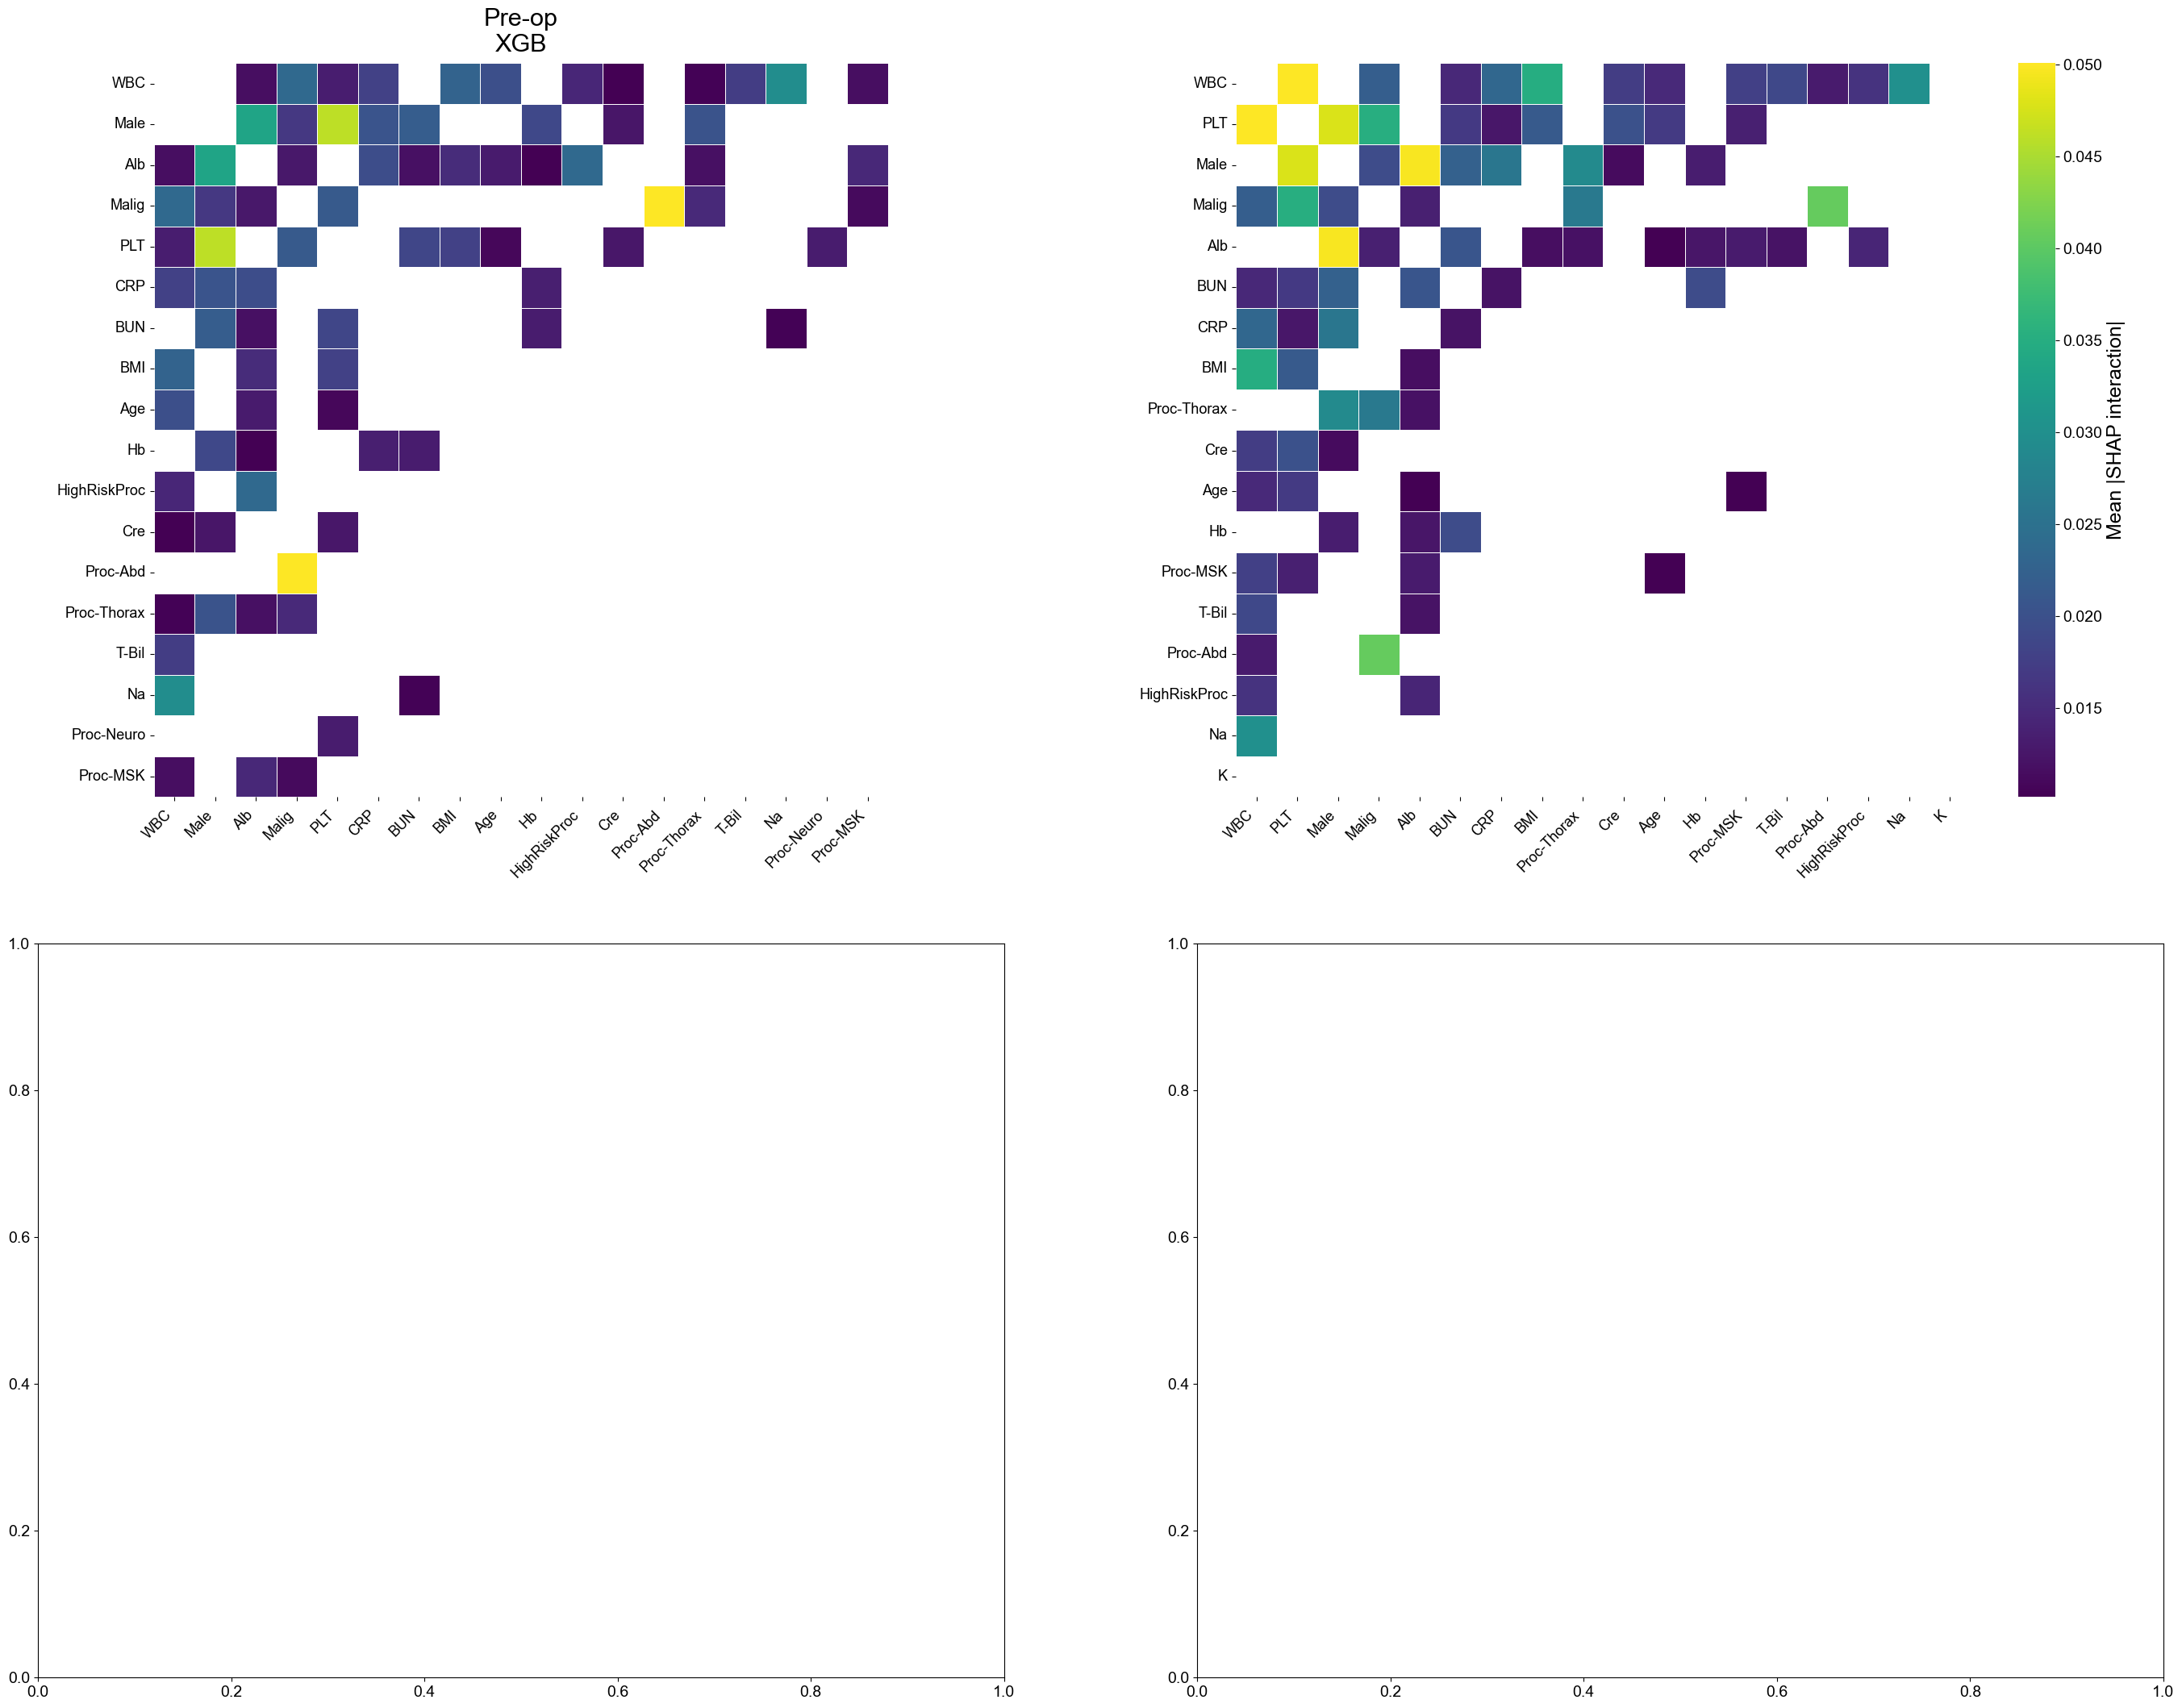

In [2]:
# -*- coding: utf-8 -*-
"""
shap_only_plots_hires.py  – 2025-08-14
────────────────────────────────────────
RESULTS_DIR に保存されている
  *_hold_model.pkl（学習済み CalibratedClassifierCV など）
  *_hold_preds.csv  （y_true, y_pred）  # ← 本コードでは未使用
を読み込み、

  1) SHAP summary plot（各モデルごとに個別 JPEG/TIFF）
  2) SHAP interaction heatmap（Pre-op / Peri-op × XGB / LGBM）
  3) SHAP mean(|value|) bar（各モデルごとに個別）
  4) 2×3 合成（summary / bar それぞれ）

を高解像度（既定 dpi=900）で保存します。
"""

import os
import re
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from PIL import Image

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# ───────── 0. 出力品質・見やすさ設定（ここを調整）
DPI_EXPORT = 900              # 900〜1200 推奨（雑誌要件に応じて調整）
SAVE_TIFF  = False            # True にすると TIFF(LZW) も同時保存
FIGSIZE_SUMMARY = (14, 10)    # SHAP summary 図サイズ
FIGSIZE_BAR     = (12, 10)    # SHAP importance bar 図サイズ
FIGSIZE_INTERACT= (34, 26)    # 2×2 heatmap 図サイズ（大きめ）
INTERACTION_TOP_K = 18        # 相互作用ヒートマップで表示する上位特徴数

# 全体のフォント（sans-serif/大きめ）
matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
})

# SHAP の警告抑制（バージョン差のメッセージ）
warnings.filterwarnings("ignore", message=".*TreeExplainer shap values output has changed.*")
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # GPU 不使用

# ───────── 1. Un-pickle 用ダミークラス（環境間互換のため）
class WinsorizeLog1pTransformer:
    def __init__(self, *_, **__): pass
    def fit(self, X, y=None): return self
    def transform(self, X): return X
    def get_feature_names_out(self, input_features=None):
        return (np.asarray(input_features, dtype=object)
                if input_features is not None else np.array([]))

# 互換名で拾われるケース対策（あなたの環境に合わせて）
import builtins
builtins.WinsorLog1pTransformer = WinsorizeLog1pTransformer

# ───────── 2. パス & 定数（必要に応じて書き換え）
RESULTS_DIR = Path(
    r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250802_0850"
)
DATA_PATH = Path(
    r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250729.xlsx"
)
RANDOM_STATE = 42

MODEL_ORDER = ["Logistic", "XGBoost", "LightGBM"]
VARIANTS = ["①Pre-op", "②Peri-op+Intra"]
VARIANT_DISPLAY_NAMES = {"①Pre-op": "①Pre-op", "②Peri-op+Intra": "②Peri-op"}
MODEL_ABBREVIATIONS = {"Logistic": "LR", "XGBoost": "XGB", "LightGBM": "LGBM"}

# 図面での表示順（存在しないものは自動的にスキップ）
ORDERED_FEATURES = [
    "Age","Male","BMI","ASA","Malig","CHF","Dialysis","WBC","Hb","PLT","Alb","CRP",
    "BUN","Cre","K","Na","T-Bil","DM Med","β-blocker","Anticoag","Antiplatelet",
    "AntiCa","Opioid","Oral steroids","Proc-Eye","Proc-Face/Neck","Proc-Thorax",
    "Proc-MSK","Proc-ENT","Proc-Neuro","Proc-Genital","Proc-Urinary","Proc-Skin",
    "Proc-Abd","ResectNum","HighRiskProc","OpTime","FluidBal","RBC Tx","FFP Tx",
    "PLT Tx","HR at 6h","MAP at 6h"
]

# ───────── 3. ヘルパー
def load_pipeline(pkl: Path):
    """CalibratedClassifierCV を元の estimator に戻す。そうでなければそのまま。"""
    with open(pkl, "rb") as f:
        mdl = pickle.load(f)
    if isinstance(mdl, CalibratedClassifierCV):
        return mdl.calibrated_classifiers_[0].estimator
    return mdl

def get_display_feature_names(original_cols):
    """ 図面表示用の名前正規化 """
    disp = []
    for col in original_cols:
        name = col
        name = name.replace("DeliMed", "DM Med")
        name = name.replace("ASA", "ASA-PS")
        disp.append(name)
    return disp

def save_with_formats(fig, path_no_ext: Path, dpi=DPI_EXPORT):
    """JPEG（必要ならTIFFも）で保存。"""
    jpg = path_no_ext.with_suffix(".jpeg")
    fig.savefig(jpg, dpi=dpi, format="jpeg", bbox_inches="tight")
    if SAVE_TIFF:
        tiff = path_no_ext.with_suffix(".tiff")
        fig.savefig(tiff, dpi=dpi, format="tiff",
                    pil_kwargs={"compression": "tiff_lzw"},
                    bbox_inches="tight")
    return jpg

def pil_save_with_dpi(img: Image.Image, path: Path, dpi=DPI_EXPORT, quality=95):
    """合成画像をPillowで保存（dpiメタ情報を付与）。"""
    img.save(path, quality=quality, dpi=(dpi, dpi))
    if SAVE_TIFF:
        img.save(path.with_suffix(".tiff"),
                 dpi=(dpi, dpi),
                 compression="tiff_lzw")

# ───────── 4. データ読み込み（hold-out 作成）
df_all = pd.read_excel(DATA_PATH)
df_all["Event"] = df_all["Event"].astype(int)
_, hold = train_test_split(
    df_all, test_size=0.2, stratify=df_all["Event"], random_state=RANDOM_STATE
)
X_hold = hold.drop(columns=["Event"])

# ───────── 5. モデルリスト収集
models_info = []
_pat = re.compile(r"(.+?)_(.+?)_hold_model\.pkl$")   # ex: ①Pre-op_LightGBM_hold_model.pkl
for pkl in RESULTS_DIR.glob("*_hold_model.pkl"):
    m = _pat.match(pkl.name)
    if not m:
        continue
    variant, model = m.groups()
    if variant in VARIANTS and model in MODEL_ORDER:
        models_info.append({"variant": variant, "model": model, "pkl": pkl})

if not models_info:
    raise RuntimeError("RESULTS_DIR に対象モデルが見つかりません。ファイル名規則を確認してください。")

# ───────── 6. SHAP summary（個別、高解像度保存）
print("Generating individual SHAP summary plots (hi-res)...")
summary_paths = []
for var in VARIANTS:
    display_var = VARIANT_DISPLAY_NAMES.get(var, var)
    for mdl in MODEL_ORDER:
        info = next((d for d in models_info if d["variant"] == var and d["model"] == mdl), None)
        if info is None:
            continue

        pipe = load_pipeline(info["pkl"])
        pre = pipe.named_steps["pre"]
        model = pipe.named_steps["model"]

        Xp = pre.transform(X_hold)
        cols = [c.split("__")[-1] for c in pre.get_feature_names_out()]
        dfp  = pd.DataFrame(Xp, columns=cols)
        disp_cols = get_display_feature_names(cols)

        if mdl == "Logistic":
            expl = shap.LinearExplainer(model, dfp, feature_perturbation="interventional")
            sv = expl.shap_values(dfp)
        else:
            expl = shap.TreeExplainer(model)
            raw = expl.shap_values(dfp)
            sv = raw[1] if isinstance(raw, list) else raw

        # SHAP の summary_plot は内部で Figure を作ることが多いので、明示的に Figure を先に用意
        fig = plt.figure(figsize=FIGSIZE_SUMMARY)
        shap.summary_plot(sv, dfp, max_display=20, show=False, feature_names=disp_cols)
        plt.title(f"{display_var}-{MODEL_ABBREVIATIONS[mdl]} SHAP", fontsize=18)
        plt.tight_layout()
        out_no_ext = RESULTS_DIR / f"SHAP_{display_var}_{MODEL_ABBREVIATIONS[mdl]}"
        jpg_path = save_with_formats(fig, out_no_ext, dpi=DPI_EXPORT)
        summary_paths.append(jpg_path)
        plt.close(fig)
print("...Done.")

# ───────── 7. SHAP interaction heatmap（2×2、可読性最適化・高解像度）
print("Generating SHAP interaction heatmap (hi-res, readability-optimized)...")
COMBOS = [("①Pre-op", "XGBoost"), ("①Pre-op", "LightGBM"),
          ("②Peri-op+Intra", "XGBoost"), ("②Peri-op+Intra", "LightGBM")]

fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_INTERACT)
axes = axes.flatten()

TITLE_FONTSIZE = 22
TICK_FONTSIZE  = 13
CBAR_FONTSIZE  = 13

for idx, (var, mdl) in enumerate(COMBOS):
    ax = axes[idx]
    display_var = VARIANT_DISPLAY_NAMES.get(var, var)
    info = next((d for d in models_info if d["variant"] == var and d["model"] == mdl), None)

    if info is None:
        ax.axis("off")
        ax.set_title(f"{display_var}-{mdl}\n(モデル無し)", fontsize=TITLE_FONTSIZE)
        continue

    pipe = load_pipeline(info["pkl"])
    pre = pipe.named_steps["pre"]
    model = pipe.named_steps["model"]
    Xp = pre.transform(X_hold)
    cols = [c.split("__")[-1] for c in pre.get_feature_names_out()]
    dfp = pd.DataFrame(Xp, columns=cols)

    expl = shap.TreeExplainer(model)
    raw = expl.shap_interaction_values(dfp)
    mat = raw[1] if isinstance(raw, list) else raw
    mat = np.abs(mat).mean(axis=0)

    disp_cols = get_display_feature_names(cols)
    mat_df = pd.DataFrame(mat, index=disp_cols, columns=disp_cols)
    np.fill_diagonal(mat_df.values, 0)

    # 強い相互作用の上位を選抜
    tot_strength = mat_df.abs().sum(axis=1).sort_values(ascending=False)
    keep = [f for f in tot_strength.index if f in ORDERED_FEATURES][:INTERACTION_TOP_K]
    if len(keep) < INTERACTION_TOP_K:
        for f in tot_strength.index:
            if f not in keep:
                keep.append(f)
            if len(keep) >= INTERACTION_TOP_K:
                break
    mat_df = mat_df.loc[keep, keep]

    # 弱い値は非表示（マスク）
    thresh = np.percentile(mat_df.values, 75)
    mask = mat_df < thresh

    show_cbar = (idx % 2 == 1)
    hm = sns.heatmap(
        mat_df, mask=mask, cmap="viridis", square=True, ax=ax,
        cbar=show_cbar,
        cbar_kws={"label": "Mean |SHAP interaction|"} if show_cbar else None,
        linewidths=0.5, linecolor="white"
    )
    ax.set_xticklabels(mat_df.columns, rotation=45, ha="right", fontsize=TICK_FONTSIZE)
    ax.set_yticklabels(mat_df.index, rotation=0, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis='x', pad=6)
    ax.tick_params(axis='y', pad=4)

    if show_cbar and hm.colorbar is not None:
        hm.colorbar.ax.tick_params(labelsize=CBAR_FONTSIZE)
        hm.colorbar.set_label("Mean |SHAP interaction|", fontsize=CBAR_FONTSIZE)

    clean_var = display_var.replace("①", "").replace("②", "")
    ax.set_title(f"{clean_var}\n{MODEL_ABBREVIATIONS[mdl]}", fontsize=TITLE_FONTSIZE, pad=10)

plt.tight_layout(pad=3.0)
# 保存（JPEG/TIFF）
out_no_ext = RESULTS_DIR / "SHAP_Interactions_2x2"
save_with_formats(fig, out_no_ext, dpi=DPI_EXPORT)
plt.close(fig)
print("...Done.")

# ───────── 8. SHAP mean(|value|) bar（個別、高解像度保存）
print("Generating individual SHAP importance bar plots (hi-res)...")
imp_paths = []
for var in VARIANTS:
    display_var = VARIANT_DISPLAY_NAMES.get(var, var)
    for mdl in MODEL_ORDER:
        info = next((d for d in models_info if d["variant"] == var and d["model"] == mdl), None)
        if info is None:
            continue

        pipe = load_pipeline(info["pkl"])
        pre = pipe.named_steps["pre"]
        model = pipe.named_steps["model"]

        Xp = pre.transform(X_hold)
        cols = [c.split("__")[-1] for c in pre.get_feature_names_out()]
        dfp  = pd.DataFrame(Xp, columns=cols)

        if mdl == "Logistic":
            expl = shap.LinearExplainer(model, dfp, feature_perturbation="interventional")
            sv = expl.shap_values(dfp)
        else:
            expl = shap.TreeExplainer(model)
            raw = expl.shap_values(dfp)
            sv = raw[1] if isinstance(raw, list) else raw

        imp = (pd.Series(np.abs(sv).mean(axis=0), index=dfp.columns)
                 .rename(index={"DeliMed": "DM Med"})
                 .sort_values(ascending=False)
                 .head(20))

        fig = plt.figure(figsize=FIGSIZE_BAR)
        sns.barplot(x=imp.values, y=imp.index, orient="h", palette="viridis")
        plt.xlabel("mean(|SHAP value|)", fontsize=16)
        plt.ylabel("")
        plt.title(f"{display_var}-{MODEL_ABBREVIATIONS[mdl]}  Feature importance (Top 20)", fontsize=18)
        plt.tight_layout()
        out_no_ext = RESULTS_DIR / f"SHAP_Importance_{display_var}_{MODEL_ABBREVIATIONS[mdl]}"
        jpg_path = save_with_formats(fig, out_no_ext, dpi=DPI_EXPORT)
        imp_paths.append(jpg_path)
        plt.close(fig)
print("...Done.")

# ───────── 9. 合成（summary 2×3、bar 2×3）— Pillow で dpi メタ情報も付与
print("Compositing SHAP summary plots (2x3, hi-res metadata)...")
# 順序固定（VARIANTS × MODEL_ORDER）
summary_grid = []
for v in VARIANTS:
    display_v = VARIANT_DISPLAY_NAMES.get(v, v)
    for m in MODEL_ORDER:
        p = RESULTS_DIR / f"SHAP_{display_v}_{MODEL_ABBREVIATIONS[m]}.jpeg"
        if p.exists():
            summary_grid.append(p)
        else:
            raise FileNotFoundError(p)

imgs = [Image.open(p) for p in summary_grid]
w, h = imgs[0].size; grid_w, grid_h = 3, 2
canvas = Image.new("RGB", (w * grid_w, h * grid_h), "white")
for idx, img in enumerate(imgs):
    r, c = divmod(idx, grid_w)
    canvas.paste(img, (c * w, r * h))
out_path = RESULTS_DIR / "SHAP_Summary_2x3.jpeg"
pil_save_with_dpi(canvas, out_path, dpi=DPI_EXPORT, quality=95)
print(f"✓ 2×3 summary saved → {out_path}")

print("Compositing SHAP importance plots (2x3, hi-res metadata)...")
imp_grid = []
for v in VARIANTS:
    display_v = VARIANT_DISPLAY_NAMES.get(v, v)
    for m in MODEL_ORDER:
        p = RESULTS_DIR / f"SHAP_Importance_{display_v}_{MODEL_ABBREVIATIONS[m]}.jpeg"
        if p.exists():
            imp_grid.append(p)
        else:
            raise FileNotFoundError(p)

imps = [Image.open(p) for p in imp_grid]
w2, h2 = imps[0].size
canvas2 = Image.new("RGB", (w2 * 3, h2 * 2), "white")
for idx, img in enumerate(imps):
    r, c = divmod(idx, 3)
    canvas2.paste(img, (c * w2, r * h2))
out_path2 = RESULTS_DIR / "SHAP_Importance_2x3.jpeg"
pil_save_with_dpi(canvas2, out_path2, dpi=DPI_EXPORT, quality=95)
print(f"✓ 2×3 importance saved → {out_path2}")

print("\nAll SHAP figures exported in high resolution!")


In [ ]:
# -*- coding: utf-8 -*-
"""
sensitivity_block_v14_fixed.py   (2025-08-01  no-early-stop safe, TS uses COMPL_PATH)
───────────────────────────────────────────────────────────
 * CC / PI-only / TS  の 3 モード一括感度解析
 * Pre-op / Peri-op+Intra 2 variant × Logistic / XGB / LGB
 * early-stopping / eval_set / callbacks → **完全に削除**
 * hold-out のみ出力（施設別・LOGO 検証なし）
 * TS モードでも COMPL_PATH を使用
"""

# ───── Imports
from __future__ import annotations
import warnings, random, pickle
from pathlib import Path
from datetime import datetime
from typing import Dict

import numpy as np, pandas as pd, optuna, xgboost as xgb, lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import RobustScaler
from sklearn.impute          import SimpleImputer
from sklearn.linear_model    import LogisticRegression
from sklearn.calibration     import CalibratedClassifierCV
from sklearn.metrics         import (roc_auc_score, average_precision_score,
                                     brier_score_loss, precision_recall_curve,
                                     f1_score)
from category_encoders        import TargetEncoder

# ───── Globals
RANDOM_STATE   = 42
N_TRIALS       = 100
PATIENCE       = 20
N_SPLITS_TUNE  = 5
N_BOOTSTRAP    = 1500
PI_COL         = "PI"

RAW_PATH   = r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\ver1_20250729.xlsx"
COMPL_PATH = r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250729.xlsx"

OUTDIR = Path(f"sens_results_{datetime.now():%Y%m%d_%H%M}")
OUTDIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ───── 1. 列定義
CAT_PRE = ["Male","Dialysis","CHF","Malig","β-blocker","Oral steroids","DeliMed",
           "Anticoag","Antiplatelet","AntiCa","Opioid","Proc-Eye","Proc-Face/Neck",
           "Proc-Thorax","Proc-MSK","Proc-ENT","Proc-Neuro","Proc-Genital",
           "Proc-Urinary","Proc-Skin","Proc-Abd","ResectNum","HighRiskProc"]
NUM_PRE = ["ASA","Age","BMI","Alb","BUN","CRP","Cre","Hb","K","Na","PLT","T-Bil","WBC"]

CAT_INTRA = CAT_PRE.copy()
NUM_INTRA = NUM_PRE + ["RBC Tx","FFP Tx","PLT Tx","FluidBal",
                       "OpTime","HR at 6h","MAP at 6h"]

VARIANTS = {"①Pre-op": (CAT_PRE, NUM_PRE),
            "②Peri-op+Intra": (CAT_INTRA, NUM_INTRA)}
MODELS = ["Logistic","XGBoost","LightGBM"]

# ───── 2. Data utilities
def drop_missing_cc(df): 
    return df.dropna(how="any").reset_index(drop=True)

def restrict_to_pi(df, event_col="Event"):
    df = df.copy()
    df[event_col] = df[PI_COL]
    return df

def identity(df): 
    return df

MODES = {"CC": drop_missing_cc, "PI": restrict_to_pi, "TS": identity}

# ───── 3. Transformer
class WinsorLog1p(SimpleImputer):
    def __init__(self, lo=.005, hi=.995, skew_thr=1.0):
        super().__init__(strategy="median")
        self.lo, self.hi, self.skew_thr = lo, hi, skew_thr
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        df = pd.DataFrame(X).astype(float)
        self.q_  = {c: df[c].quantile([self.lo, self.hi]).values for c in df}
        self.log_ = {c: (df[c]>=0).all() and abs(df[c].skew())>self.skew_thr for c in df}
        df = self._pre(df)
        super().fit(df.values)
        self.scaler.fit(super().transform(df.values))
        return self

    def transform(self, X):
        df = self._pre(pd.DataFrame(X).astype(float))
        return self.scaler.transform(super().transform(df.values))

    def _pre(self, df):
        for c in df:
            lo, hi = self.q_[c]
            df[c] = df[c].clip(lo, hi)
            if self.log_[c]:
                df[c] = np.log1p(df[c])
        return df

# ───── 4. Metric helpers
def _metrics(y, p):
    eps = 1e-15
    p_clip = np.clip(p, eps, 1-eps)
    lr1 = LogisticRegression().fit(np.log(p_clip/(1-p_clip)).reshape(-1,1), y)
    lr2 = LogisticRegression().fit(np.log(p_clip/(1-p_clip)).reshape(-1,1), y)
    slope, intercept = lr1.coef_[0][0], lr2.intercept_[0]
    return (roc_auc_score(y, p),
            average_precision_score(y, p),
            brier_score_loss(y, p),
            slope, intercept)

def ci_boot(y, p, n=N_BOOTSTRAP):
    rng = np.random.RandomState(RANDOM_STATE)
    idx = np.arange(len(y))
    stats = np.array([_metrics(y[s], p[s]) for s in rng.choice(idx, (n, len(idx)), True)])
    pt = _metrics(y, p)
    lo, hi = np.percentile(stats, [2.5, 97.5], axis=0)
    keys = ["AUROC","PR_AUC","Brier","CalSlope","CalInt"]
    return {k: (pt[i], lo[i], hi[i]) for i, k in enumerate(keys)}

def best_f1(y, p):
    pr, rc, thr = precision_recall_curve(y, p)
    f1 = 2 * pr * rc / (pr + rc + 1e-15)
    i = int(np.nanargmax(f1))
    return (thr[i] if i < len(thr) else 1.0, f1[i])

# ───── 5. Estimators & pipeline
def xgb_gpu():
    return dict(tree_method="gpu_hist", predictor="gpu_predictor",
                device="cuda", random_state=RANDOM_STATE,
                enable_categorical=False)

def lgb_gpu():
    try:
        return dict(device="gpu")
    except:
        return {}

def build_estimator(name, pos_w):
    if name == "Logistic":
        mdl = LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE)
        space = {"model__C": optuna.distributions.FloatDistribution(1e-3, 10, log=True)}
    elif name == "XGBoost":
        mdl = xgb.XGBClassifier(objective="binary:logistic", eval_metric="aucpr",
                                n_estimators=600, **xgb_gpu())
        space = {
            "model__max_depth": optuna.distributions.IntDistribution(3, 8),
            "model__learning_rate": optuna.distributions.FloatDistribution(1e-3, 3e-2, log=True),
            "model__subsample": optuna.distributions.FloatDistribution(.5, .9),
            "model__colsample_bytree": optuna.distributions.FloatDistribution(.5, .9),
            "model__scale_pos_weight": optuna.distributions.FloatDistribution(.5 * pos_w, 1.5 * pos_w)
        }
    else:  # LightGBM
        mdl = lgb.LGBMClassifier(objective="binary", metric="aucpr",
                                 n_estimators=600, random_state=RANDOM_STATE, **lgb_gpu())
        space = {
            "model__num_leaves": optuna.distributions.IntDistribution(31, 127),
            "model__learning_rate": optuna.distributions.FloatDistribution(1e-3, 3e-2, log=True),
            "model__feature_fraction": optuna.distributions.FloatDistribution(.5, .9),
            "model__bagging_fraction": optuna.distributions.FloatDistribution(.5, .9),
            "model__bagging_freq": optuna.distributions.IntDistribution(1, 5),
            "model__scale_pos_weight": optuna.distributions.FloatDistribution(.5 * pos_w, 1.5 * pos_w)
        }
    return mdl, space

def build_pipe(model, cat, num):
    tr = []
    if cat:
        tr.append(("cat", Pipeline([
            ("enc", TargetEncoder(cols=cat, smoothing=0.3, handle_unknown="impute")),
            ("imp", SimpleImputer(strategy="most_frequent"))
        ]), cat))
    if num:
        tr.append(("num", Pipeline([
            ("win", WinsorLog1p())
        ]), num))
    pre = ColumnTransformer(tr, remainder="drop" if tr else "passthrough")
    return Pipeline([("pre", pre), ("model", model)])

# ───── 6. CV (no early-stop, no eval_set)
def cv_predict(pipe, X: pd.DataFrame, y):
    cv = StratifiedKFold(n_splits=N_SPLITS_TUNE, shuffle=True, random_state=RANDOM_STATE)
    oof = np.empty(len(y))
    for tr, va in cv.split(X, y):
        pipe.fit(X.iloc[tr], y[tr])
        oof[va] = pipe.predict_proba(X.iloc[va])[:, 1]
    return oof

# ───── 7. Optuna tuner
def tune(pipe, space, X, y):
    def obj(trial):
        for prm, dist in space.items():
            if isinstance(dist, optuna.distributions.FloatDistribution):
                pipe.set_params(**{prm: trial.suggest_float(prm, dist.low, dist.high, log=dist.log)})
            elif isinstance(dist, optuna.distributions.IntDistribution):
                pipe.set_params(**{prm: trial.suggest_int(prm, dist.low, dist.high)})
        p = cv_predict(pipe, X, y)
        return average_precision_score(y, p)

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    study.optimize(
        obj, n_trials=N_TRIALS,
        callbacks=[lambda s, t: s.stop() if t.number - s.best_trial.number >= PATIENCE else None],
        show_progress_bar=False
    )
    pipe.set_params(**study.best_params)
    best = {k.replace("model__", ""): v for k, v in study.best_params.items()}
    return pipe, best

# ───── 8. Variant runner
def run_variant(Xd, yd, Xh, yh, cat, num, mdl_name):
    pos_w = (yd == 0).sum() / max((yd == 1).sum(), 1)
    base, space = build_estimator(mdl_name, pos_w)
    pipe, best = tune(build_pipe(base, cat, num), space, Xd, yd)

    clf = CalibratedClassifierCV(pipe, method="isotonic", cv=N_SPLITS_TUNE)
    clf.fit(Xd, yd)
    p = clf.predict_proba(Xh)[:, 1]

    ci = ci_boot(yh, p)
    thr, f1b = best_f1(yh, p)

    rng = np.random.RandomState(RANDOM_STATE)
    f1bs = [
        f1_score(yh[s], (p[s] >= thr).astype(int))
        for s in rng.choice(np.arange(len(yh)), (N_BOOTSTRAP, len(yh)), True)
    ]
    lo, hi = np.percentile(f1bs, [2.5, 97.5])
    ci["F1_best"] = (f1b, lo, hi)
    ci["F1_thr"] = (thr, np.nan, np.nan)

    flat = {k: v[0] for k, v in ci.items()}
    flat.update({f"{k}_lo": v[1] for k, v in ci.items()})
    flat.update({f"{k}_hi": v[2] for k, v in ci.items()})

    # F1@0.20
    thr20 = 0.20
    f1_20 = f1_score(yh, (p >= thr20).astype(int))
    f1_20bs = [
        f1_score(yh[s], (p[s] >= thr20).astype(int))
        for s in rng.choice(np.arange(len(yh)), (N_BOOTSTRAP, len(yh)), True)
    ]
    lo20, hi20 = np.percentile(f1_20bs, [2.5, 97.5])
    flat["F1_020"] = f1_20
    flat["F1_020_lo"] = lo20
    flat["F1_020_hi"] = hi20

    return clf, flat, best, p

# ───── 9. Sensitivity loop
for mode, prep in MODES.items():
    print(f"\n=== Mode: {mode} ===")
    # CC のみ RAW、PI/TS は COMPL
    path = RAW_PATH if mode == "CC" else COMPL_PATH
    print(f"Reading from: {path}")
    df = pd.read_excel(path).set_index("INDEX")
    df = prep(df)

    if mode == "TS":
        period_col = "Period24_25"
        # 存在チェック
        if period_col not in df.columns:
            print(f"Warning: '{period_col}' column not found, skipping TS mode.")
            continue
        dev_df  = df[df[period_col] == 0]
        test_df = df[df[period_col] == 1]
        if "Event" not in df.columns or test_df["Event"].sum() < 40:
            print(" -> Event<40 or 'Event' missing, skip TS mode.")
            continue
    else:
        dev_df, test_df = train_test_split(
            df, test_size=0.20, stratify=df["Event"], random_state=RANDOM_STATE
        )

    Xd, yd = dev_df.drop("Event", axis=1), dev_df["Event"].values
    Xh, yh = test_df.drop("Event", axis=1), test_df["Event"].values

    res, hp = [], []
    for vname, (cat_raw, num_raw) in VARIANTS.items():
        CAT = [c for c in cat_raw if c in df.columns]
        NUM = [n for n in num_raw if n in df.columns]
        for mdl in MODELS:
            print(f"  {vname} – {mdl}")
            clf, met, best, p_hold = run_variant(Xd, yd, Xh, yh, CAT, NUM, mdl)
            res.append({"Mode": mode, "Variant": vname, "Model": mdl, **met})
            hp.append({"Mode": mode, "Variant": vname, "Model": mdl, **best})

            # save
            with open(OUTDIR / f"{mode}_{vname}_{mdl}.pkl", "wb") as f:
                pickle.dump(clf, f)
            pd.DataFrame({
                "Index": test_df.index,
                "y_true": yh,
                "y_pred": p_hold
            }).to_csv(OUTDIR / f"{mode}_{vname}_{mdl}_preds.csv", index=False)

    pd.DataFrame(res).to_excel(
        OUTDIR / f"{mode}_summary_metrics.xlsx", index=False, float_format="%.4f")
    pd.DataFrame(hp).to_excel(
        OUTDIR / f"{mode}_selected_hyperparameters.xlsx", index=False)

print("\n✓ Sensitivity analyses finished →", OUTDIR.resolve())


In [ ]:
# -*- coding: utf-8 -*-
"""
dca_only_analysis.py - 2025-08-03
Script for generating DCA plots and aggregated tables only.
"""

from __future__ import annotations
import os, warnings, pickle
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

# ───────── Const
# ★ User must specify these paths
RESULTS_DIR = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250802_0850")
DATA_PATH = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250729.xlsx")
RANDOM_STATE = 42

MODEL_ORDER = {"Logistic": 0, "XGBoost": 1, "LightGBM": 2}
MODEL_ABBREVIATIONS = {
    "Logistic": "LR",
    "XGBoost": "XGB",
    "LightGBM": "LGBM"
}

os.environ["CUDA_VISIBLE_DEVICES"] = ""
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ───────── Helper
def net_benefit(y_true: np.ndarray, y_pred: np.ndarray, thr: float) -> float:
    """Calculates net benefit for a given threshold."""
    n = len(y_true)
    tp = ((y_pred >= thr) & (y_true == 1)).sum()
    fp = ((y_pred >= thr) & (y_true == 0)).sum()
    if thr == 1:
        return 0.0 # Avoid division by zero
    return tp / n - fp / n * (thr / (1 - thr))

def calculate_metrics_at_threshold(y_true, y_pred, threshold):
    """Calculates a set of metrics for a given threshold."""
    # Handle thresholds that result in no positive predictions
    if (y_pred >= threshold).sum() == 0:
        return 0, 1, 0, 1, 0 # Sensitivity, PPV, NetBenefit are 0
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    net_b = net_benefit(y_true, y_pred, threshold)
    return sensitivity, specificity, ppv, npv, net_b

# ───────── 1. モデル & 予測読み込み
models_info: List[Dict] = []
for pkl in RESULTS_DIR.glob("*_hold_model.pkl"):
    stem = pkl.stem
    if not stem.endswith("_hold_model"):
        continue
    base = stem[:-11]
    if "_" not in base:
        continue
    variant, model = base.rsplit("_", 1)
    csv = pkl.with_name(base + "_hold_preds.csv")
    if not csv.exists():
        continue
    dfp = pd.read_csv(csv)
    if {"y_true", "y_pred"}.issubset(dfp.columns):
        models_info.append(dict(
            variant=variant, model=model,
            y_true=dfp.y_true.values,
            y_pred=dfp.y_pred.values
        ))

if not models_info:
    raise RuntimeError("対象ファイルが見つかりません。")

# 指定順(Logistic→XGB→LGBM)で並べ替え
models_info.sort(
    key=lambda d: (d["variant"], MODEL_ORDER.get(d["model"], 99))
)
print("✓ Models and predictions loaded successfully.")

# ───────── 2. hold-out prevalence
df_all = pd.read_excel(DATA_PATH)
_, hold = train_test_split(df_all, test_size=0.2,
                           stratify=df_all.Event, random_state=RANDOM_STATE)
prev = hold.Event.mean()
print(f"✓ Hold-out prevalence calculated: {prev:.4f}")

# ───────── 3. DCA plot
threshs = np.linspace(0.01, 0.5, 50)
plt.figure(figsize=(8, 6))
for info in models_info:
    nb = [net_benefit(info["y_true"], info["y_pred"], t) for t in threshs]
    model_abbr = MODEL_ABBREVIATIONS.get(info["model"], info["model"])
    plt.plot(threshs, nb, label=f'{info["variant"]}-{model_abbr}')
plt.plot(threshs, np.zeros_like(threshs), "--", label="Treat None", color="black")
plt.plot(threshs, prev - (1 - prev) * (threshs / (1 - threshs)),
         "--", label="Treat All", color="gray")
plt.xlabel("Threshold"); plt.ylabel("Net benefit")
plt.title("Decision Curve (hold-out)")
plt.xlim(0, 0.5); plt.ylim(-0.15, 0.15)
plt.legend(fontsize=10)
plt.tight_layout()
dca_plot_path = RESULTS_DIR / "DCA_AllModels.jpeg"
plt.savefig(dca_plot_path, dpi=300)
plt.close()
print(f"✓ DCA plot saved to: {dca_plot_path}")

# ───────── 4. Detailed DCA table
print("\n── Generating detailed Decision Threshold Table... ──")
df_rows = []
thresholds_for_table = np.linspace(0.001, 1.0, 1000)

for info in models_info:
    for thr in thresholds_for_table:
        sens, spec, ppv, npv, nb = calculate_metrics_at_threshold(
            info["y_true"], info["y_pred"], thr
        )
        df_rows.append({
            'Variant': info["variant"],
            'Model': info["model"],
            'Threshold': thr,
            'Sensitivity': sens,
            'Specificity': spec,
            'PPV': ppv,
            'NPV': npv,
            'NetBenefit': nb
        })
df_thr = pd.DataFrame(df_rows)
csv_path = RESULTS_DIR / 'Decision_Threshold_Table.csv'
df_thr.to_csv(csv_path, index=False)
print(f"✓ Detailed Decision Threshold Table saved to: {csv_path}")

# ───────── 5. Aggregated DCA table
print("\n── Aggregating Decision Threshold Table... ──")
df_thr = pd.read_csv(csv_path)

bins = np.arange(0, 1.0001, 0.05)
labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

df_thr['ThresholdInterval'] = pd.cut(
    df_thr['Threshold'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

interval_mid = {
    label: (float(label.split('-')[0]) + float(label.split('-')[1])) / 2
    for label in labels
}

df_interval = (
    df_thr
    .groupby(['Variant', 'Model', 'ThresholdInterval'], dropna=False)
    .agg({
        'Sensitivity': 'mean',
        'Specificity': 'mean',
        'PPV': 'mean',
        'NPV': 'mean',
        'NetBenefit': 'mean'
    })
    .reset_index()
)

df_interval['RepresentativeThreshold'] = df_interval['ThresholdInterval'].map(interval_mid)

cols = [
    'Variant', 'Model', 'ThresholdInterval', 'RepresentativeThreshold',
    'Sensitivity', 'Specificity', 'PPV', 'NPV', 'NetBenefit'
]
df_interval = df_interval[cols]

out_path = RESULTS_DIR / 'Decision_Threshold_Table_Aggregated.xlsx'
df_interval.to_excel(out_path, index=False)
print(f"✓ Aggregated Decision Threshold Table saved to: {out_path}")

print("\nAll DCA-related tasks completed.")